In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
dimension_33d = pd.read_csv('../input_data/RelDim_labels/dimensions_33d.csv',index_col=0)
dimension_33d = dimension_33d.iloc[:,0].to_list() 

relationships = pd.read_csv('../input_data/RelDim_labels/159relationships_fix_label.csv',index_col=0)
relationships = relationships.iloc[:,0].to_list()

key = pd.read_csv('../input_data/RelDim_labels/credamo_question_key.csv')

Helper function

In [3]:
def clean_data(vnum,region,Qstart,Qend):
    """
    separate different parts from all items
    parameter:
        vnum: the version of survey
        region: data collecting in region / country
        Qstart,Qend: control the item index of main questions

    output:
        'main': main part of questions
        'dim_com': comprehension of dimensions
        'rel_size': check items
        'familiarity': familiarity of relationships rated
    """
    result_df = {}
    #import data
    file_path = '../input_data/Nations/'+region+'/'+region+'_'+str(vnum)+'.csv'
    raw_data = pd.read_csv(file_path,index_col=None, header=1,encoding='UTF-8')
    #drop 'suggestion'
    raw_reorg = raw_data.drop(['Q42'], axis=1)
    raw_reorg['subject'] = list(raw_reorg.index)
    raw_reorg = raw_reorg.reset_index(drop=True)
    
    response = raw_reorg
    response['subject'] = list(raw_reorg.index)
    response = response.loc[:,response.columns.str.startswith('Q')]
    
    
    #Questionnaires
    #main question:V1,Q4-14;V2,Q15-Q25;V3,Q26-Q33,Q35-Q36,Q38
    count = Qstart
    filtered_main = []
    while count <= Qend:
        [filtered_main.append(col) for col in raw_reorg if col.startswith('Q'+str(count)+'_2')]
        if count == 33 or count == 36:
            count = count + 2
        else:
            count += 1
    response_main = response[filtered_main]

    #check_rel_size:Q39,Q40
    filtered_rel_size = [col for col in raw_reorg if (col.startswith('Q39'))|(col.startswith('Q40'))]
    response_rel_size = response[filtered_rel_size]
    
    #familiarity: Q0
    filtered_familiarity = [col for col in raw_reorg if (col.startswith('Q0'))]
    response_familiarity = response[filtered_familiarity]

    #dim_comprehension
    count = Qstart
    filtered_dim_com = []
    while count <= Qend:
        [filtered_dim_com.append(col) for col in raw_reorg if col.startswith('Q'+str(count)+'_1')]
        if count == 33 or count == 36:
            count += 2
        else:
            count += 1
    response_dim_com = response[filtered_dim_com]
    
    #demographics
    count = 3
    filtered_demo = [col for col in raw_reorg if col.startswith('Q41')]
    response_demo = response[filtered_demo]

    #output
    result_df['main'] = response_main
    result_df['dim_com'] = response_dim_com
    result_df['rel_size'] = response_rel_size
    result_df['familiarity'] = response_familiarity
    result_df['demographic'] = response_demo
    return result_df

In [4]:
def combine_data(region,*data_type):
    """
    combine data in three versions into one whole response
    parameter:
        region: data collecting in region / country
        data_type = ['main','dim_com','rel_size','familiarity']

    output:
        the same as clean_data()
    """
    result_df = {}
    vnum_list = [1,2,3]
    Qstart_list = [4,15,26]
    Qend_list = [14,25,38]

    for data in data_type:
        for vnum,Qstart,Qend in zip(vnum_list,Qstart_list,Qend_list):
            if vnum == 1:
                all_data = clean_data(vnum,region,Qstart,Qend)[data]

            else:   
                temp = clean_data(vnum,region,Qstart,Qend)[data]
                all_data = pd.concat([all_data,temp])
        result_df[data] = all_data

    return result_df

# Clean and combine data

## credamo

In [5]:
data_type = ['main','dim_com','rel_size','familiarity','demographic']
clean_dict_all = combine_data('India',*data_type)

response_credamo = clean_dict_all['main']
foils_rel_size_credamo = clean_dict_all['rel_size']
familiarity_credamo = clean_dict_all['familiarity']
response_dim_com_credamo = clean_dict_all['dim_com']

In [6]:
dimension_frames_credamo = {}
count = 4
for dim in dimension_33d:  # exclude foil and demographics ## change this variable
    filtered_cols = [col for col in response_credamo if col.startswith('Q'+str(count)+'_2')] ## change this variable 
    dimension_frames_credamo[dim] = pd.DataFrame(response_credamo[filtered_cols])
    dimension_frames_credamo[dim].columns = relationships
    if count == 33 or count == 36:
        count = count +2
    else:
        count = count+1

## qualtrics

In [7]:
# version1
raw_v1 = pd.read_csv('../input_data/Nations/India/SR_33d_INDI_1_merge.csv',encoding='UTF-8')
raw_v1_reorg = raw_v1.drop(axis='index',index=[0,1])
raw_v1_reorg['subject'] = list(raw_v1_reorg.index)
raw_v1_reorg = raw_v1_reorg.reset_index(drop=True)
raw_v1_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v1_reorg['Duration (in seconds)'])

response_v1 = raw_v1_reorg
response_v1['subject'] = list(raw_v1_reorg.index)
response_v1 = response_v1.loc[:, response_v1.columns.str.startswith('Q')]

# version2
raw_v2 = pd.read_csv('../input_data/Nations/India/SR_33d_INDI_2_merge.csv',encoding='UTF-8')
raw_v2_reorg = raw_v2.drop(axis='index',index=[0,1])
raw_v2_reorg['subject'] = list(raw_v2_reorg.index)
raw_v2_reorg = raw_v2_reorg.reset_index(drop=True)
raw_v2_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v2_reorg['Duration (in seconds)'])

response_v2 = raw_v2_reorg
response_v2['subject'] = list(raw_v2_reorg.index)
response_v2 = response_v2.loc[:, response_v2.columns.str.startswith('Q')]

# version3
raw_v3 = pd.read_csv('../input_data/Nations/India/SR_33d_INDI_3_merge.csv',encoding='UTF-8')
raw_v3_reorg = raw_v3.drop(axis='index',index=[0,1])
raw_v3_reorg['subject'] = list(raw_v3_reorg.index)
raw_v3_reorg = raw_v3_reorg.reset_index(drop=True)
raw_v3_reorg['Duration (in seconds)'] = pd.to_numeric(raw_v3_reorg['Duration (in seconds)'])

response_v3 = raw_v3_reorg
response_v3['subject'] = list(raw_v3_reorg.index)
response_v3 = response_v3.loc[:, response_v3.columns.str.startswith('Q')]

# combine all versions
raw_reorg_qualtrics = pd.concat([raw_v1_reorg,raw_v2_reorg,raw_v3_reorg])
responses_qualtrics = pd.concat([response_v1,response_v2,response_v3])
# Get total number of response
print("Total number of response from qualtrics - "+str(len(responses_qualtrics)))

#####################################################################################
# Check rel foils to exclude people
filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith(('Q39','Q40'))]
foil_items = raw_v1[filtered_cols].iloc[0]
foil_items = [s.replace(' 鈥?', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
foil_items = [i.replace('Victim-Criminal','Victim and Criminal') for i in foil_items]
foil_items = [i.replace('Driver - Passenger','Driver and Passenger') for i in foil_items]
foil_items = [i.replace('Parent-Infant','Parent and Infant') for i in foil_items]

foils_rel_size = pd.DataFrame(responses_qualtrics[filtered_cols])
foils_rel_size.columns = foil_items
foils_rel_size = foils_rel_size.reset_index(drop = True) # after combing all versions, reset index
foils_rel_size = foils_rel_size.apply(pd.to_numeric)
foils_rel_size_new = pd.DataFrame(columns = foils_rel_size.columns.unique())
for col in foils_rel_size.columns.unique().to_list():
    foils_list = []
    foils_df = foils_rel_size[col]
    for i in foils_df.index.to_list():
        foils = foils_df.loc[i,:].dropna().values[0]
        foils_list.append(foils)

    foils_rel_size_new[col] = foils_list
foils_rel_size = foils_rel_size_new

filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith(('Q0'))]
familiarity = pd.DataFrame(raw_reorg_qualtrics[filtered_cols])
familiarity.columns = relationships
familiarity = familiarity.reset_index(drop = True) # after combing all versions, reset index
#familiarity['subject'] = raw_reorg_qualtrics['subject']
familiarity = familiarity.apply(pd.to_numeric)

#dim_comprehension
count = 4
filtered_dim_com = []
while count <= 38:
    [filtered_dim_com.append(col) for col in raw_reorg_qualtrics if col.startswith('Q'+str(count)+'.1')]
    if count == 33 or count == 36:
        count += 2
    else:
        count += 1
response_dim_com = responses_qualtrics[filtered_dim_com]
                     
dimension_frames_qualtrics = {}
count=4
for dim in dimension_33d: 
    if count == 34 or count == 37:
        count = count + 1
    filtered_cols = [col for col in raw_reorg_qualtrics if col.startswith('Q'+str(count)+'.2')]
    dimension_frames_qualtrics[dim] = pd.DataFrame(responses_qualtrics[filtered_cols])
    dimension_frames_qualtrics[dim].columns = relationships
    count=count+1
    
foils_rel_size_qualtrics = foils_rel_size
familiarity_qualtrics = familiarity
response_dim_com_qualtrics = response_dim_com

Total number of response from qualtrics - 283


## combine data

In [8]:
#the order: credamo, qualtrics
dimension_frames = {}
for dim in dimension_33d:
    temp_df = pd.concat([dimension_frames_credamo[dim],dimension_frames_qualtrics[dim]])
    temp_df = temp_df.reset_index(drop=True)
    dimension_frames[dim] = temp_df
    
# check standard   
foils_rel_size_qualtrics.columns = foils_rel_size_credamo.columns
foils_rel_size = pd.concat([foils_rel_size_credamo,foils_rel_size_qualtrics])
foils_rel_size = foils_rel_size.reset_index(drop=True)

familiarity_qualtrics.columns = familiarity_credamo.columns
familiarity = pd.concat([familiarity_credamo,familiarity_qualtrics])
familiarity = familiarity.reset_index(drop=True)

In [9]:
num_response = pd.DataFrame(columns=dimension_33d)
for dim in dimension_33d:
    num_response[dim] = dimension_frames[dim].count() 

print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimension_33d)))

'''Check total number of responses for each word
'''

print("Total number of responses, including all participants - "+str(len(dimension_frames[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of relationships - 159
Total number of dimensions - 33
Total number of responses, including all participants - 803
Smallest number of ratings for a relationship - 6
Largest number of ratings for a relationship - 23


# Dimension comprehension

<AxesSubplot:xlabel='variable', ylabel='value'>

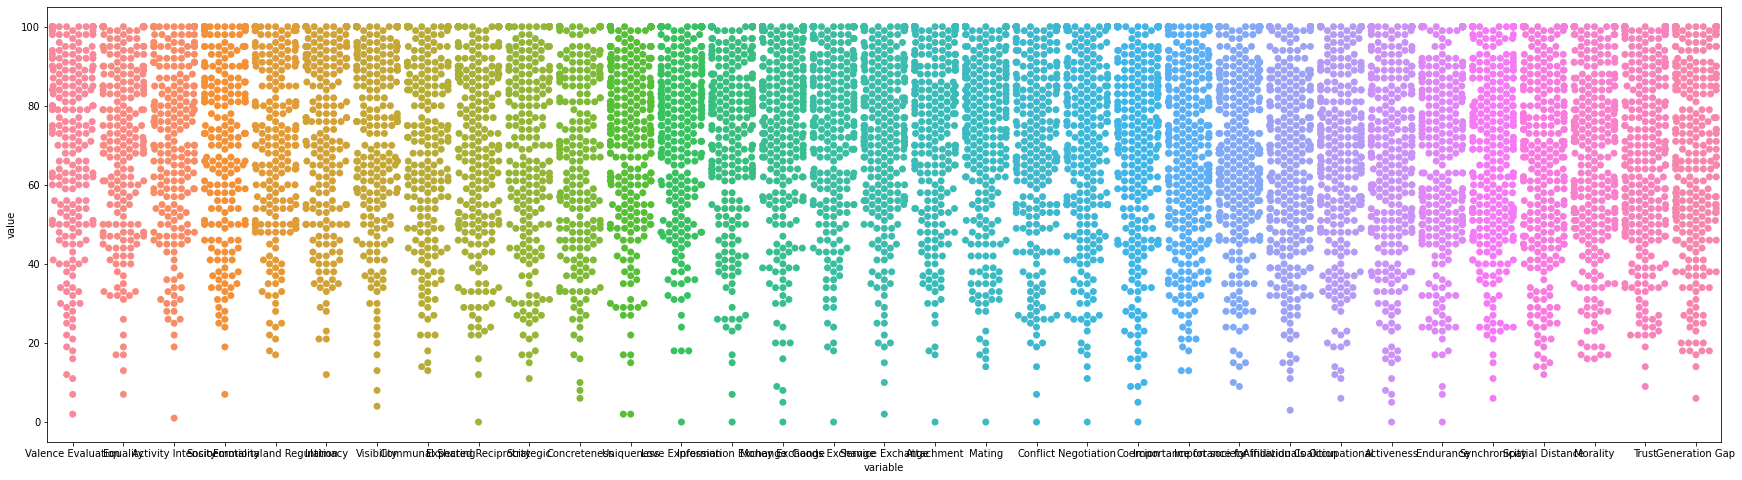

In [10]:
# comprehension of dimensions
response_dim_com_credamo = response_dim_com_credamo.reset_index(drop=True)
response_dim_com_qualtrics = response_dim_com_qualtrics.reset_index(drop=True)
response_dim_com_qualtrics.columns = response_dim_com_credamo.columns
response_dim_com = pd.concat([response_dim_com_credamo,response_dim_com_qualtrics])
response_dim_com = response_dim_com.reset_index(drop=True)
response_dim_com = response_dim_com.apply(pd.to_numeric)
dim_com_df_v1 = pd.DataFrame(columns=dimension_33d[0:11])
dim_com_df_v2 = pd.DataFrame(columns=dimension_33d[11:22])
dim_com_df_v3 = pd.DataFrame(columns=dimension_33d[22:33])

# due to the different sample in different version, separate conditon to extract items
count = 4
for dim in dimension_33d:
    filiter_dim = [col for col in response_dim_com.columns if (col.startswith('Q'+str(count)))]
    if count == 33 or count == 36:
        count += 2
    else:
        count +=1
    temp_df = response_dim_com[filiter_dim]
    temp_df = temp_df.dropna(how='all')
    
    dim_list_v1 = []
    dim_list_v2 = []
    dim_list_v3 = []
    if count <= 15:
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v1.append(value)
        dim_com_df_v1[dim] = dim_list_v1
        
    if (count > 15) & (count <= 26):
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v2.append(value)
        dim_com_df_v2[dim] = dim_list_v2
        
    if count > 26:
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v3.append(value)
        dim_com_df_v3[dim] = dim_list_v3

# transform wide into long format
dim_com_df_v1_melt = pd.melt(dim_com_df_v1)
dim_com_df_v2_melt = pd.melt(dim_com_df_v2)
dim_com_df_v3_melt = pd.melt(dim_com_df_v3)
dim_com_df_melt = pd.concat([dim_com_df_v1_melt,dim_com_df_v2_melt,dim_com_df_v3_melt],axis=0)

plt.figure(figsize=(30,8))
sns.swarmplot(data=dim_com_df_melt,x='variable',y='value',size=7)

# Filter and form dictionary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total number of responses, excluding bad participants - 563
Smallest number of ratings for a relationship - 3
Largest number of ratings for a relationship - 16


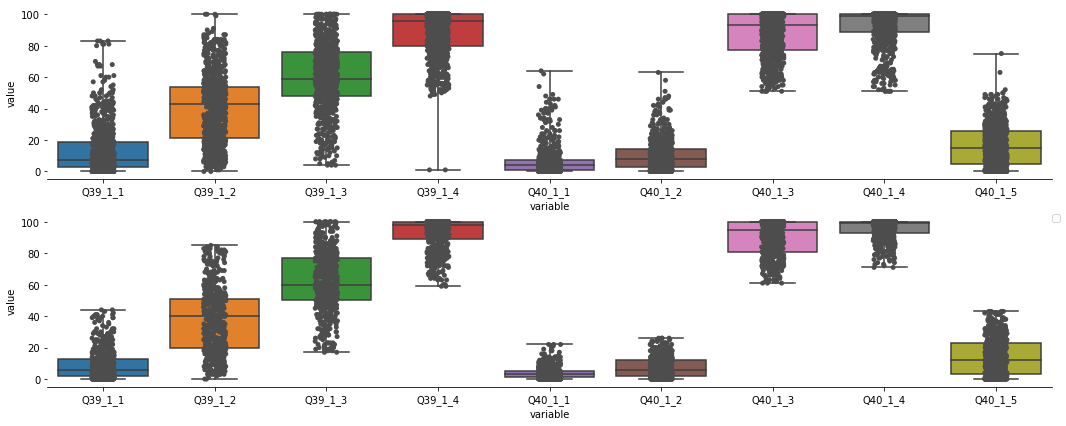

In [11]:
std = 2
foils_rel_size['subject'] = foils_rel_size.index.to_list()
foils_rel_size = foils_rel_size.apply(pd.to_numeric)
foils_rel_size_melt = pd.melt(foils_rel_size, id_vars='subject')
foils_rel_size_melt.columns = ['subject','variable','value']
outliers_rel_size_list = []
for col in foils_rel_size.columns[:-1]:
    outliers_rel_size_list = outliers_rel_size_list + list(foils_rel_size[(foils_rel_size[col] > 
                   foils_rel_size[col].mean()+foils_rel_size[col].std()*std) |
                   (foils_rel_size[col] < 
                    foils_rel_size[col].mean()-foils_rel_size[col].std()*std)].index)
outliers_rel_size_list = set(outliers_rel_size_list)

foil_rel_size_outliers = foils_rel_size
foil_rel_size_outliers = foil_rel_size_outliers[~foil_rel_size_outliers.index.isin(outliers_rel_size_list)]
foil_rel_size_outliers_melt = pd.melt(foil_rel_size_outliers, id_vars='subject')
foil_rel_size_outliers_melt.columns = ['subject','variable','value']

f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_rel_size_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_rel_size_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_rel_size_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_rel_size_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


#check familiarity
familiarity['subject'] = familiarity.index.to_list()
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='subject')

#Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] > 
                   familiarity[col].mean()+familiarity[col].std()*3.5) |
                   (familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

#remove outliers from original data
outliers_all_list = set(list(outliers_rel_size_list) + list(familiarity_list))
outliers_all_list_df = pd.DataFrame(outliers_all_list)
#outliers_all_list_df.to_csv('../output_data/outlier_df/'+region+'.csv')
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

#Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimension_33d)
for dim in dimension_33d:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 
#

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

In [12]:
with pd.ExcelWriter('../dict_results/India.xlsx') as writer:
    for dim in dimension_frames_outliers.keys():
        dimension_frames_outliers[dim].to_excel(writer,sheet_name = dim)

# Demographic

In [12]:
outlier_df = pd.read_csv('../output_data/outlier_df/India.csv',index_col=0)
outlier_df_list = outlier_df.iloc[:,0].to_list()
foils_rel_size = foils_rel_size.reset_index(drop=True)
foils_rel_size_outliers = foils_rel_size[~foils_rel_size.index.isin(outlier_df_list)]
foils_rel_size_outliers.to_csv('../output_data/foils_rel_size/India.csv')
familiarity = familiarity.reset_index(drop=True)
familiarity_outliers = familiarity[~familiarity.index.isin(outlier_df_list)]
familiarity_outliers.to_csv('../output_data/familiarity/India.csv')

response_demographic_credamo = clean_dict_all['demographic'].iloc[:,2:]
response_demographic_qualtrics = responses_qualtrics.loc[:,
                            responses_qualtrics.columns.str.startswith('Q41')].iloc[:,1:]
response_demographic_qualtrics.columns = response_demographic_credamo.columns
response_demographic = pd.concat([response_demographic_credamo,response_demographic_qualtrics])
response_demographic = response_demographic.reset_index(drop=True)
response_demographic = response_demographic[~response_demographic.index.isin(outlier_df_list)]
#response_demographic = response_demographic.apply(pd.to_numeric)

response_demographic.columns = ['Age','Gender','Race','Race_alternative',
                                'Highest education','First language']

In [13]:
dim_com_df = pd.concat([dim_com_df_v1,dim_com_df_v2,dim_com_df_v3])
dim_com_df = dim_com_df.reset_index(drop=True)
dim_com_df_outliers = dim_com_df[~dim_com_df.index.isin(outlier_df_list)]
dim_com_df_outliers.to_csv('../output_data/dimension_comprehension/India.csv')

## Gender

In [13]:
# replace index to corresponding label
# gender_map = {1:'Female',2:'Male'}
response_demographic['Gender_label'] = response_demographic['Gender']
response_demographic['Gender_label'][response_demographic['Gender'] == 1] = 'Female'
response_demographic['Gender_label'][response_demographic['Gender'] == 2] = 'Male'
response_demographic['Gender_label'].value_counts()

Male      369
Female    194
Name: Gender_label, dtype: int64

## Age

In [15]:
age = response_demographic['Age']
age[age=='1996'] = 27
age[age=='Sixty'] = 60
age = age.apply(int)

age_df = pd.DataFrame(columns = ['age','count'])
age_df['age'] = range(1,121)
count_df = []
for i in range(1,121):
    count = 0
    for j in age:
        if i == j:
            count = count + 1
    count_df.append(count)
age_df['count'] = count_df
age_df.to_csv('../output_data/demographic/India/age_df.csv')

## Race

In [16]:
race_map = {1:'White','White':'White',2:'Black','Black':'Black',
            3:'South Asian Indian, Pakistani, etc.',
            'South Asian Indian, Pakistani, etc.':'South Asian Indian, Pakistani, etc.',
            4:'East Asian Chinese, Japanese, etc.',
            'East Asian Chinese, Japanese, etc.':'East Asian Chinese, Japanese, etc.',
            5:'Arabic, Central Asian','Arabic, Central Asian':'Arabic, Central Asian',
            6:'Other (write in)','Other (write in)':'Other (write in)'}
response_demographic['Race_label'] = response_demographic['Race'].map(race_map)
response_demographic['Race_label'].value_counts()

South Asian Indian, Pakistani, etc.    549
Other (write in)                         4
East Asian Chinese, Japanese, etc.       4
White                                    3
Black                                    2
Arabic, Central Asian                    1
Name: Race_label, dtype: int64

## Highest education

In [14]:
edu_map = {1:'Early childhood education/no education',
           'Early childhood education/no education':'Early childhood education/no education',
           2:'Primary education','Primary education':'Primary education',
           3:'Lower secondary education','Lower secondary education':'Lower secondary education',
           4:'Upper secondary education','Upper secondary education':'Upper secondary education',
           5:'Post-secondary non-tertiary education','Post-secondary non-tertiary education':'Post-secondary non-tertiary education',
           6:'Short-cycle tertiary education','Short-cycle tertiary education':'Short-cycle tertiary education',
           7:'Bachelor or equivalent','Bachelor or equivalent':'Bachelor or equivalent',
           8:'Master or equivalent','Master or equivalent':'Master or equivalent',
           9:'Doctoral or equivalent','Doctoral or equivalent':'Doctoral or equivalent',
           10:'Don\'t know/No answer','Don\'t know/No answer':'Don\'t know/No answer'}
response_demographic['Highest education_label'] = response_demographic['Highest education'].map(edu_map)
response_demographic['Highest education_label'].value_counts()

Bachelor or equivalent                   396
Master or equivalent                     151
Upper secondary education                  8
Post-secondary non-tertiary education      3
Doctoral or equivalent                     3
Lower secondary education                  1
Primary education                          1
Name: Highest education_label, dtype: int64

In [15]:
response_demographic.to_csv('../output_data/demographic/India.csv')

## First language

In [18]:
response_demographic['First language'].value_counts()

tamil                       111
English                      90
Tamil                        78
english                      42
TAMIL                        41
Hindi                        40
Malayalam                    28
ENGLISH                      26
malayalam                    20
Telugu                       12
hindi                        11
telugu                        9
Malayalam                     7
Kannada                       4
marathi                       4
Marathi                       3
HINDI                         3
English                       3
MALAYALAM                     3
Bengali                       3
Hindi                         2
Gujarati                      2
Marathi                       2
TELUGU                        2
URDU                          1
Tamil and english             1
Assamese                      1
Tamil, English, kannada       1
malyalam                      1
marthi                        1
Tamilu                        1
Hindi, E

# Heatmap

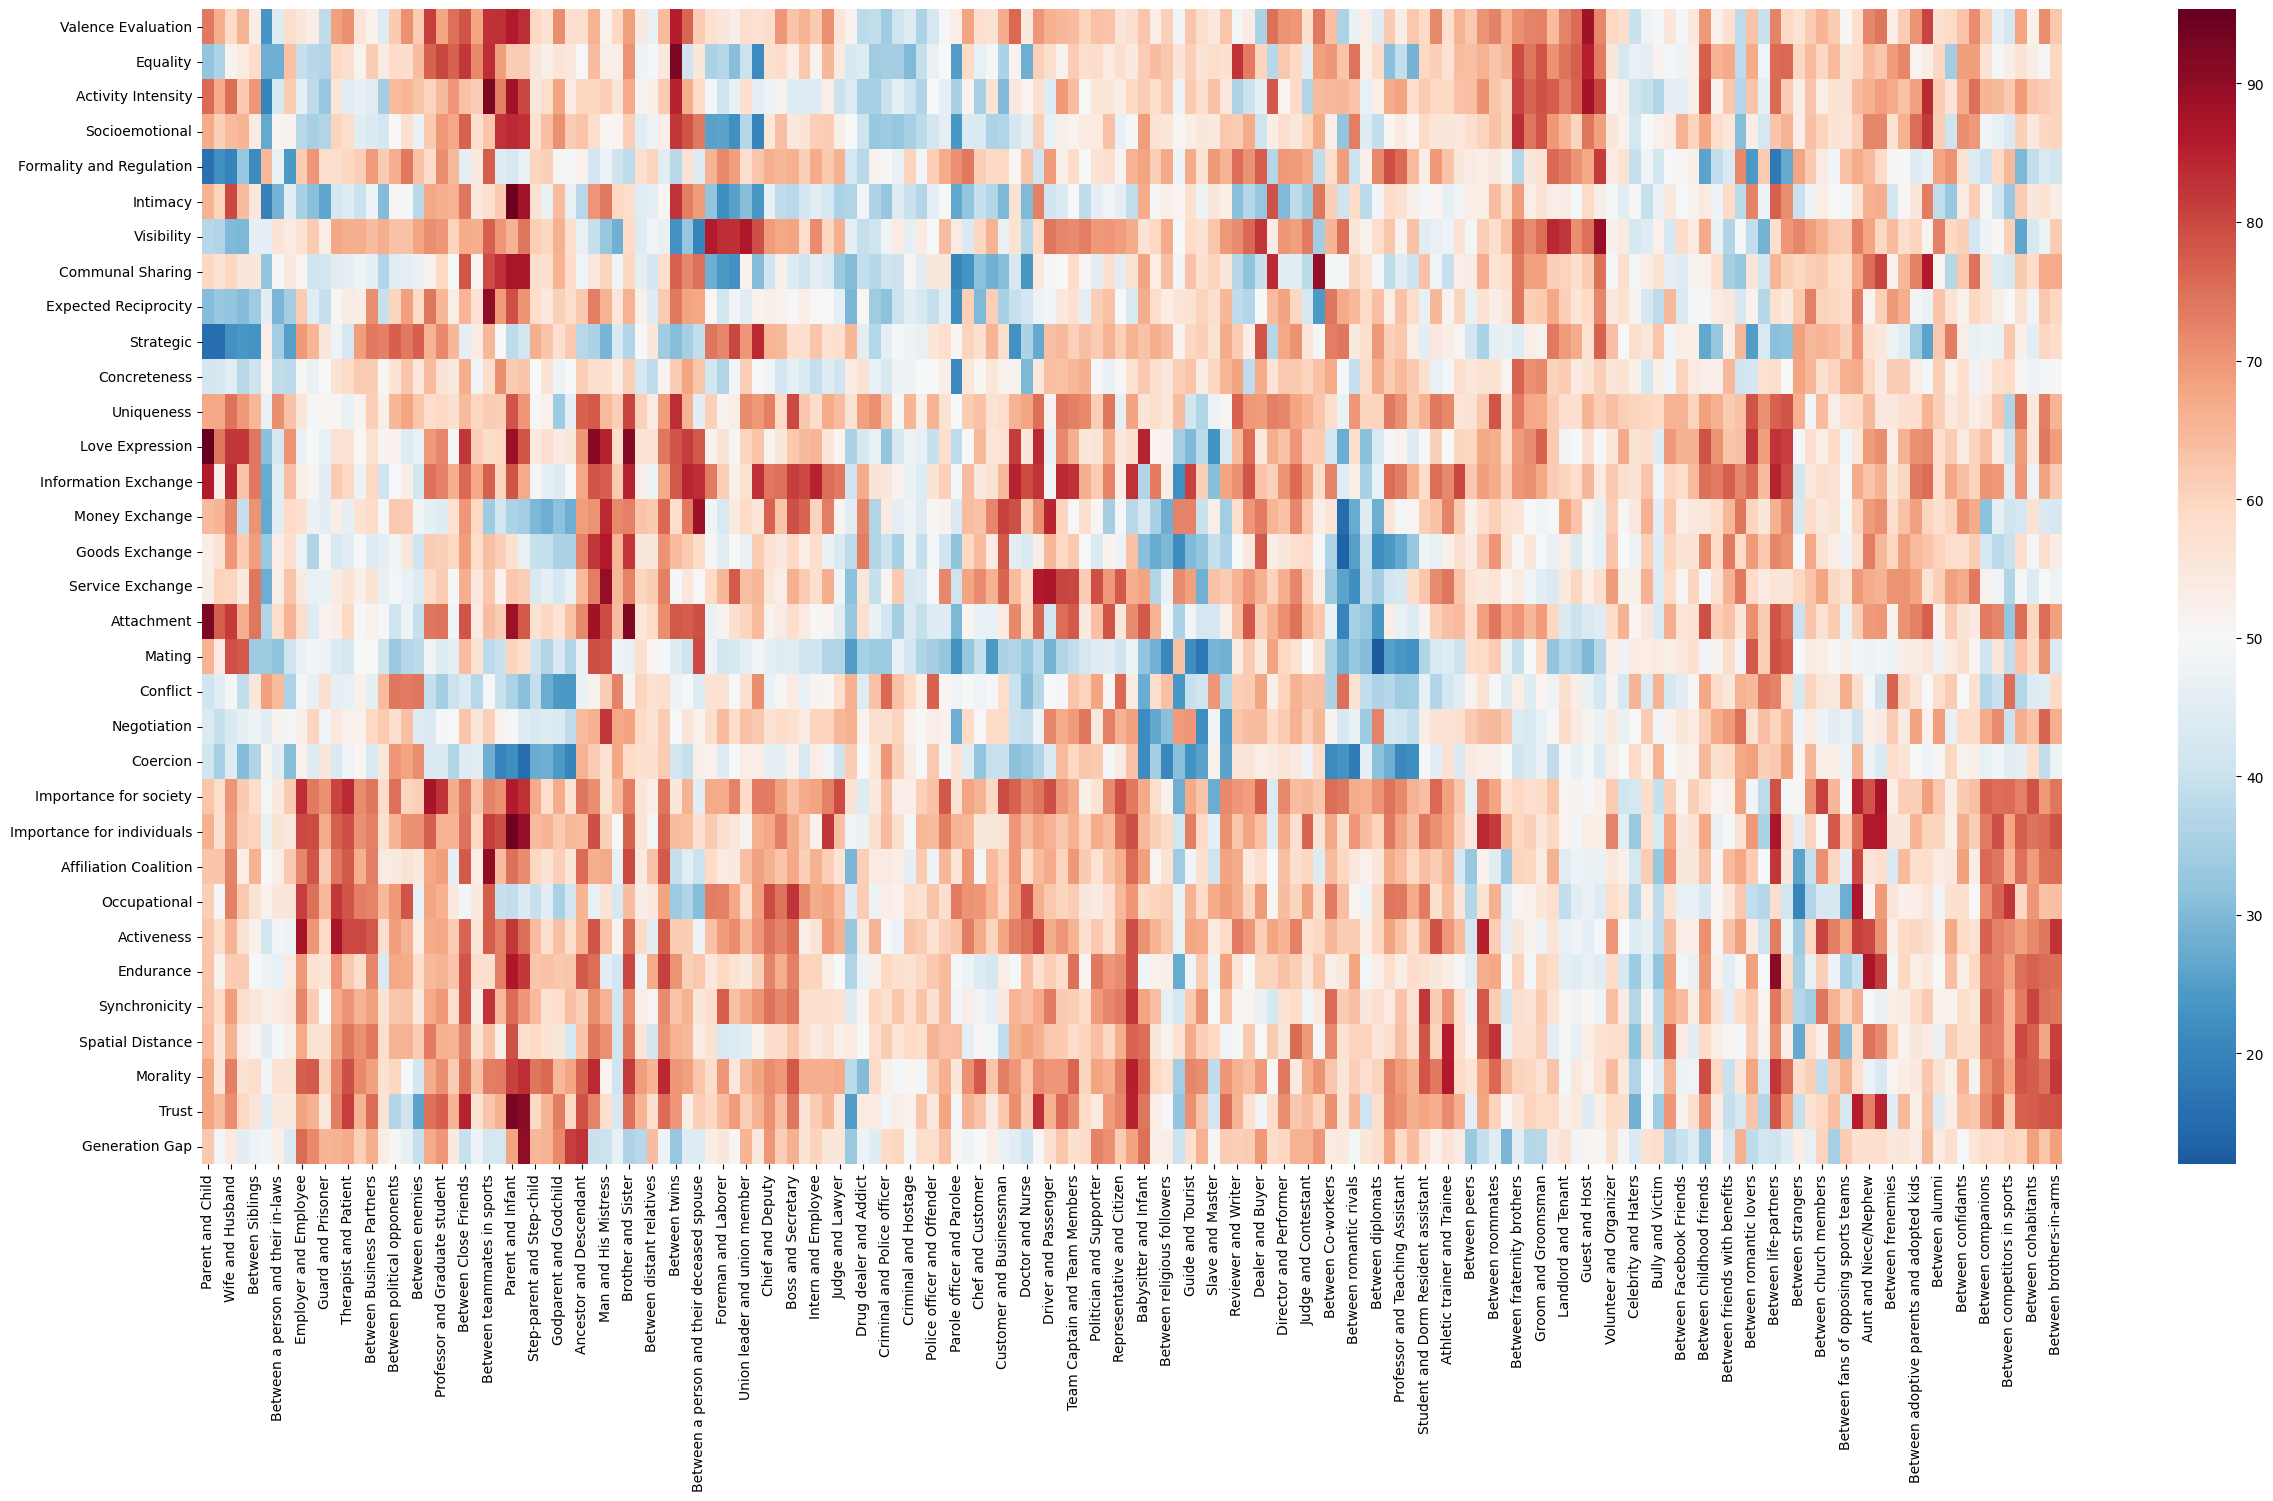

In [19]:
result_dict = dimension_frames_outliers
dim_rel = pd.DataFrame(columns=relationships)
count=0
col_names = []
for dim in result_dict.keys():
    dim_rel.loc[count] = result_dict[dim].mean().tolist()
    col_names.append(dim)
    count = count + 1
dim_rel.index = result_dict.keys()
dim_rel.to_csv('../output_data/cleaning_results/India/India_dim_rel.csv')
dim_rel.iloc[0:30,:].to_csv('../output_data/cleaning_results/India/India_dim_rel_30d.csv')

plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('../output_data/cleaning_results/India/India_dim_rel_scaled.csv')
dim_rel_scaled_df.iloc[:,0:30].to_csv('../output_data/cleaning_results/India/India_dim_rel_scaled_30d.csv')

# PCA with varimax rotation

In [2]:
library(tidyverse)
library(reshape)

library(psych)
#optimal number of components
library(nFactors)

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(corrplot)

Warning message:
"程辑包'tidyverse'是用R版本4.1.3 来建造的"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"程辑包'ggplot2'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'tibble'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'tidyr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'readr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'purrr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'dplyr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'stringr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'forcats'是用R版本4.1.3 来建造的"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"程辑包'reshape'是用R版本4.1.3 来建造的"

载入程辑包：'reshape'


The following object is masked from 'package:dplyr':

In [3]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

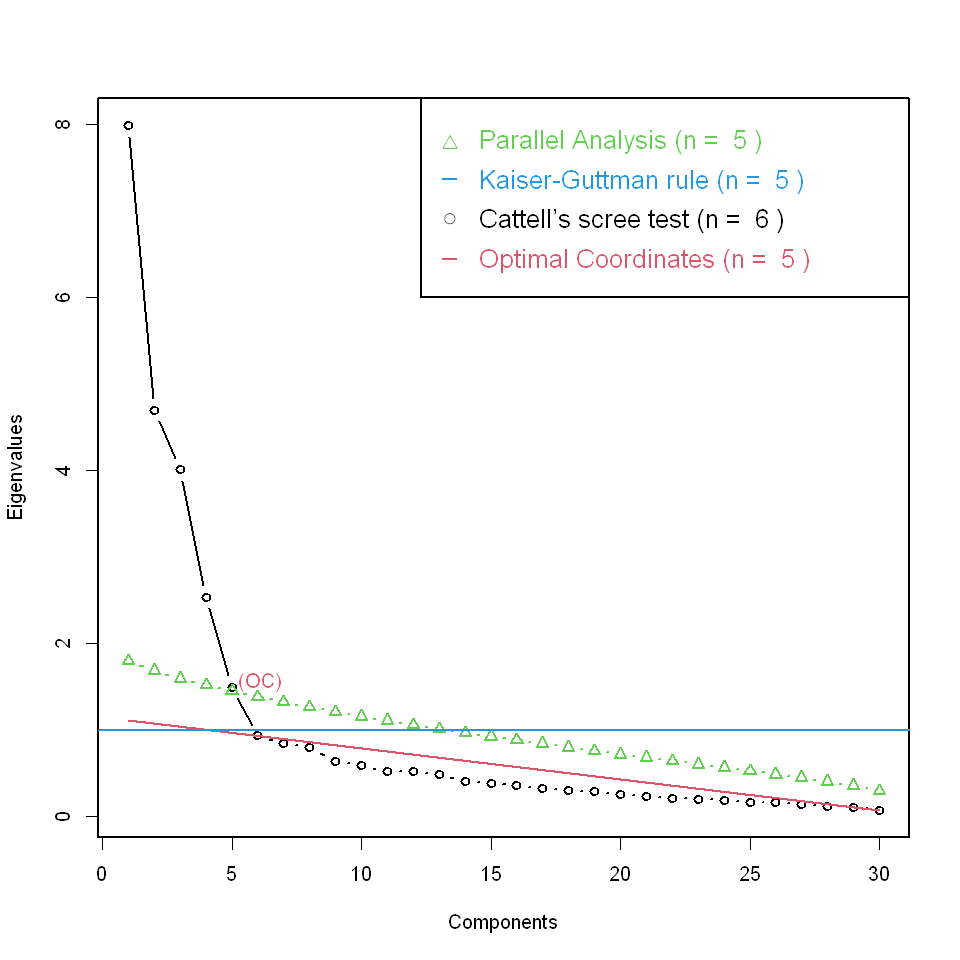

In [4]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('../output_data/cleaning_results/India/India_dim_rel_scaled_30d.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 6, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## 5d solution

In [5]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/India/India_loadings_var_5c_30d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/India/India_scores_var_5c_30d.csv')

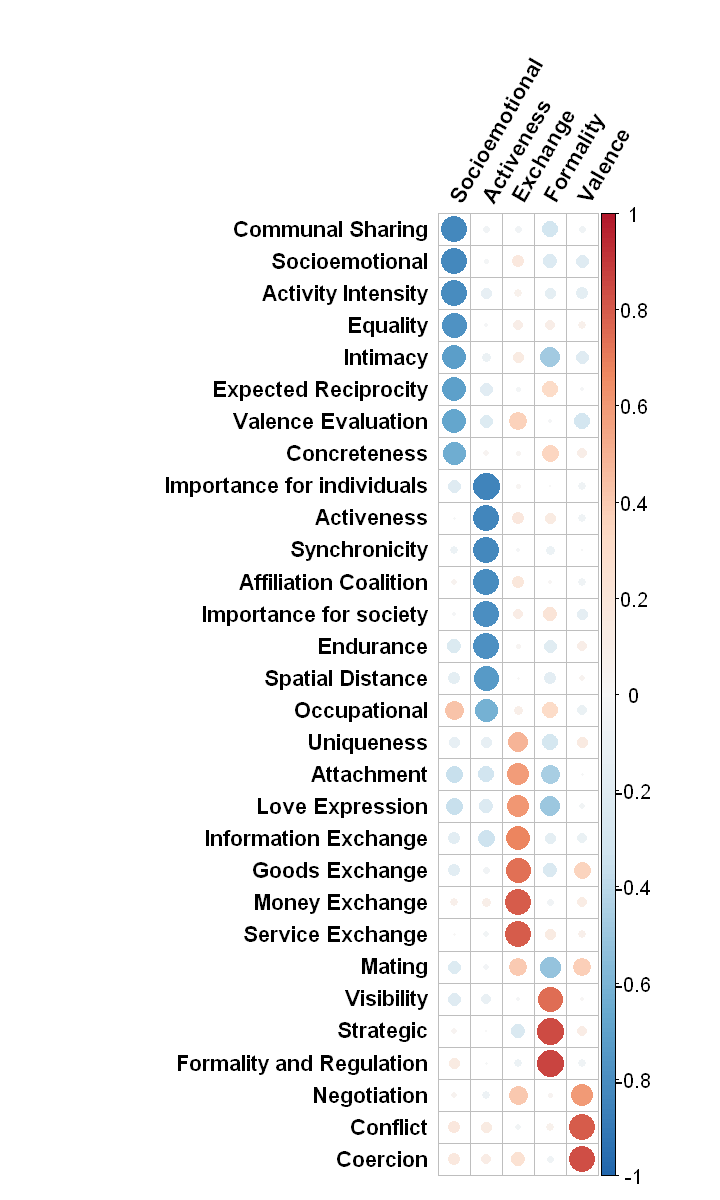

In [6]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Socioemotional','Activeness','Exchange','Formality','Valence')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

Warning message:
"程辑包'ggrepel'是用R版本4.1.3 来建造的"


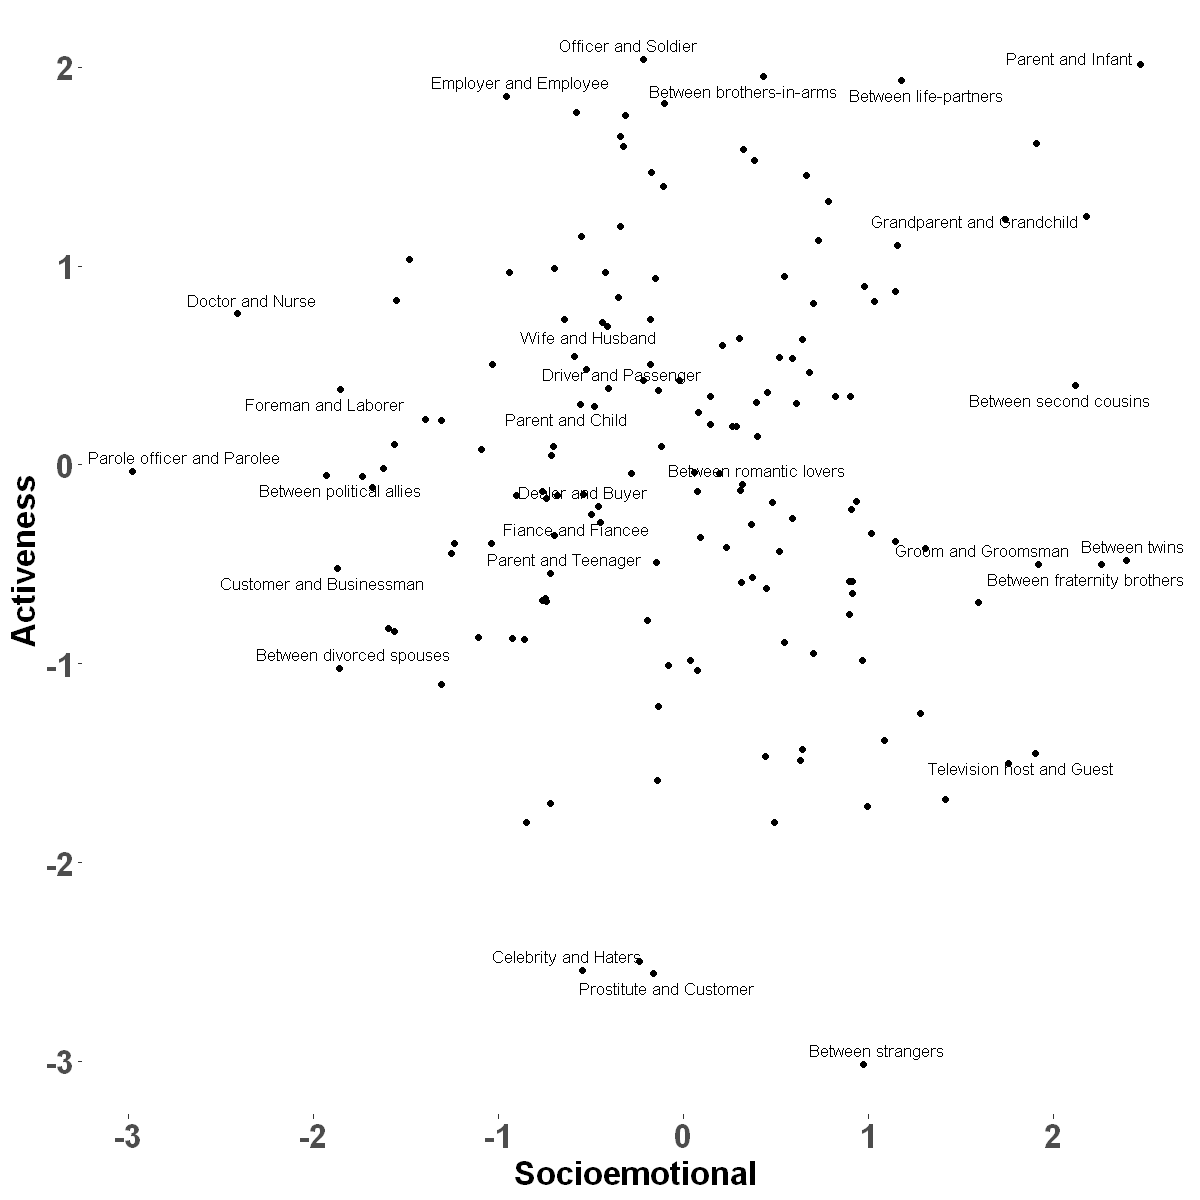

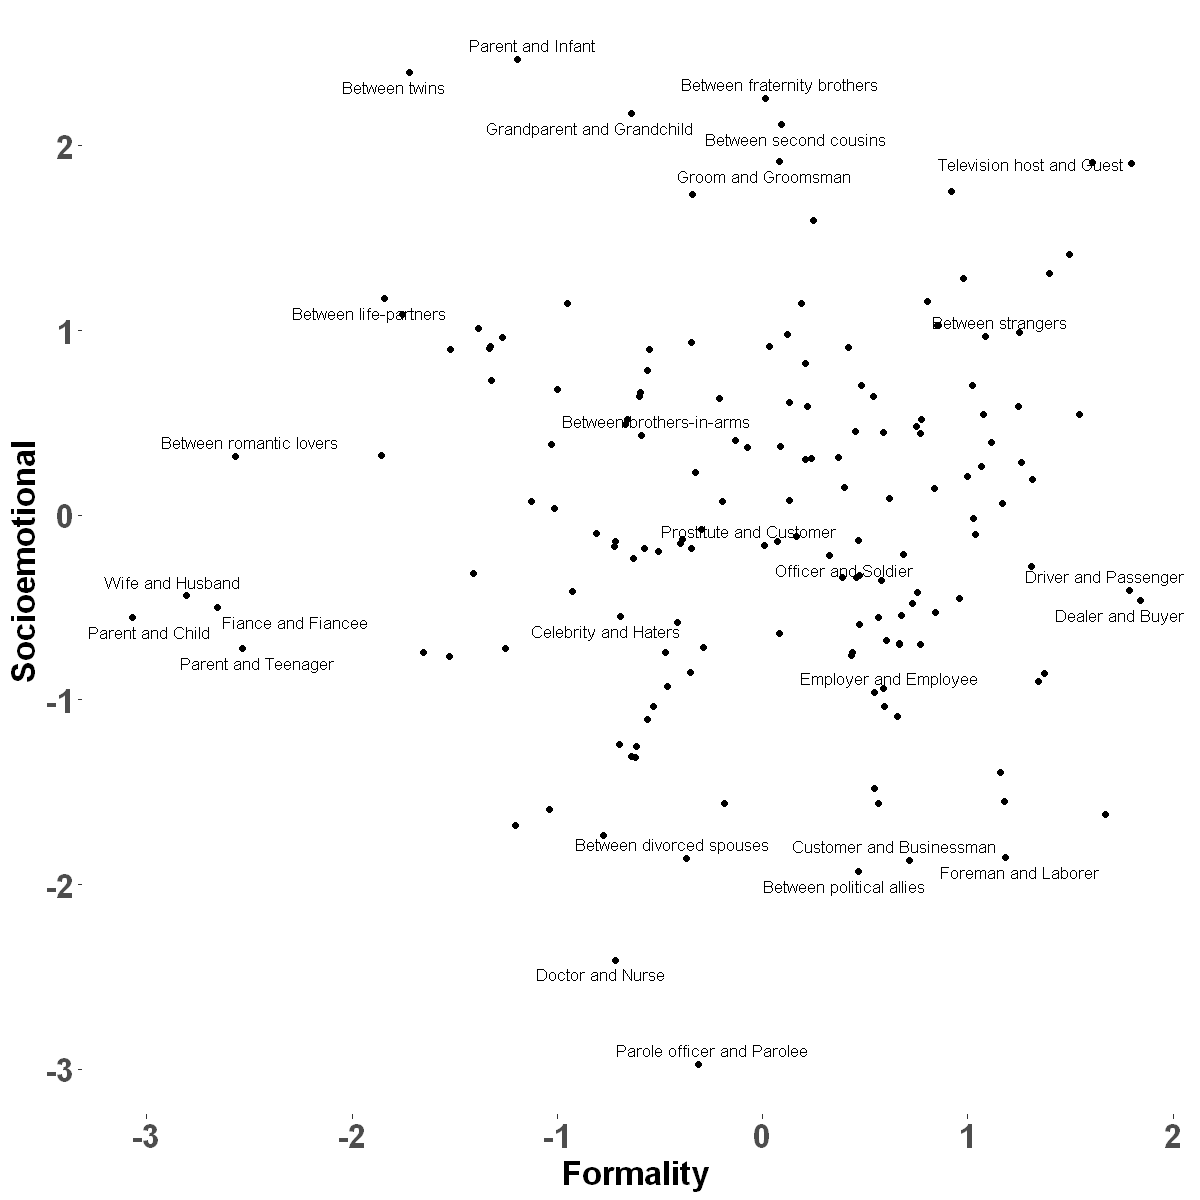

In [7]:
library(ggrepel)
num = 3
show_rel = c(rownames(scores_var[order(scores_var$V1),])[1:6],
             rownames(scores_var[order(scores_var$V1),])[159-6+1:159],
             rownames(scores_var[order(scores_var$V2),])[1:5],
             rownames(scores_var[order(scores_var$V2),])[159-num+1:159],
             #rownames(scores_var[order(scores_var$V3),])[1:5],
             #rownames(scores_var[order(scores_var$V3),])[159-num+1:159],
             rownames(scores_var[order(scores_var$V4),])[1:5],
             rownames(scores_var[order(scores_var$V4),])[159-num+1:159]
             #rownames(scores_var[order(scores_var$V5),])[1:5],
             #rownames(scores_var[order(scores_var$V5),])[159-num+1:159]
             )
scores_var_plot = scores_var
colnames(scores_var_plot) = c('Socioemotional','Activeness','Exchange','Formality','Valence')
scores_var_plot['Socioemotional'] = -scores_var_plot['Socioemotional']
scores_var_plot['Activeness'] = -scores_var_plot['Activeness']
scores_var_plot['Valence'] = -scores_var_plot['Valence']

scores_var_plot['rel'] = rownames(scores_var_plot)
show_rel_df = scores_var_plot %>% filter(rel %in% show_rel)

options(repr.plot.width=10,repr.plot.height=10)
ggplot(scores_var_plot,aes(x=Socioemotional,y=Activeness))+
geom_point()+
geom_text_repel(data=show_rel_df,aes(label=rel),size=3.5)+
#scale_size_continuous(range = c(3,6.5))+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      legend.title=element_text(face="bold",size=20),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.text=element_text(size=20,face='bold'),
      legend.position='top',
      legend.text=element_text(face="bold",size=20))

ggplot(scores_var_plot,aes(x=Formality,y=Socioemotional))+
geom_point()+
geom_text_repel(data=show_rel_df,aes(label=rel),size=3.5)+
#scale_size_continuous(range = c(3,6.5))+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      legend.title=element_text(face="bold",size=20),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.text=element_text(size=20,face='bold'),
      legend.position='top',
      legend.text=element_text(face="bold",size=20))

## 4d solution

In [8]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 4

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/India/India_loadings_var_4c_30d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/India/India_scores_var_4c_30d.csv')

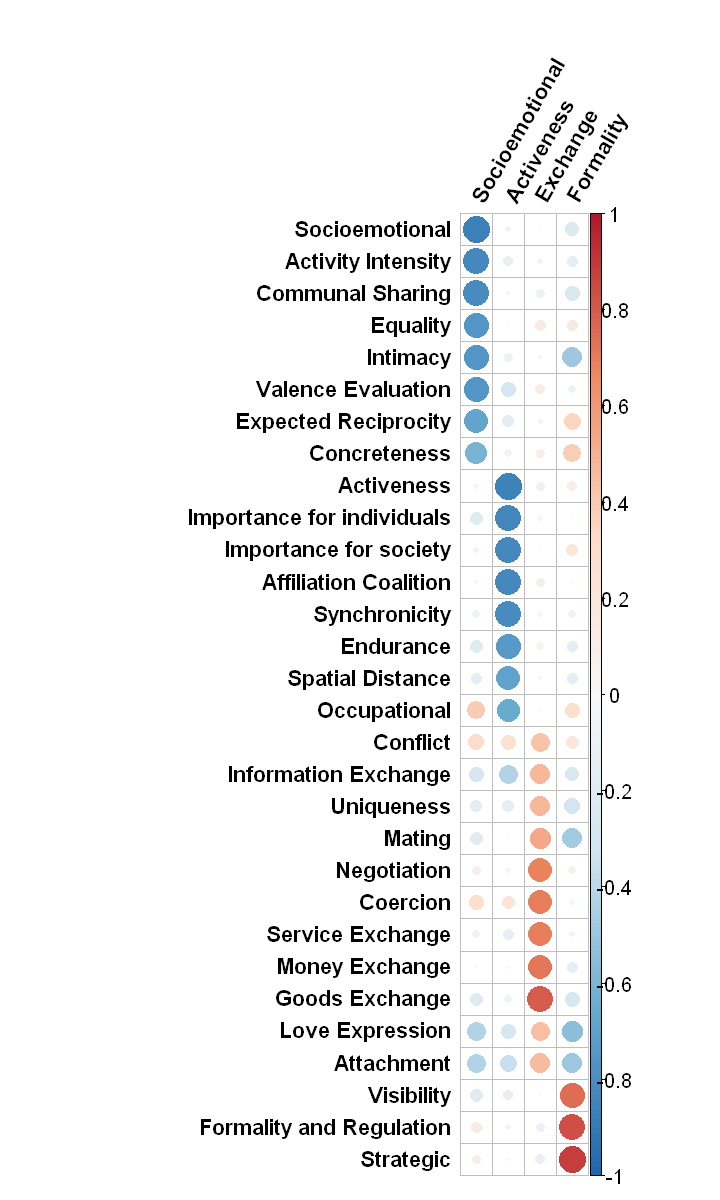

In [9]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:4)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4)
loadings_var_reorder = loadings_var_reorder[1:4]

colnames(loadings_var_reorder) = c('Socioemotional','Activeness','Exchange','Formality')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 6d solution

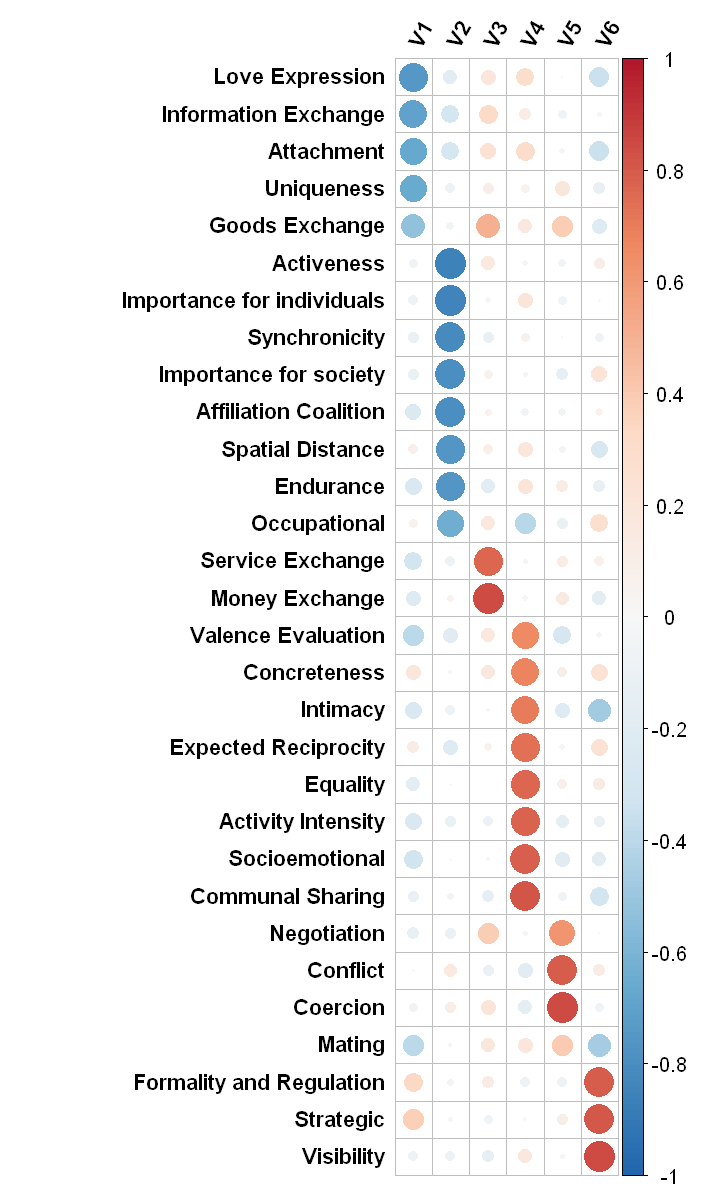

In [10]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 6

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:6)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(V6)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6)
loadings_var_reorder = loadings_var_reorder[1:6]

#colnames(loadings_var_reorder) = c('Socioemotional','Formality','Exchange','Valence','Activeness')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 33d

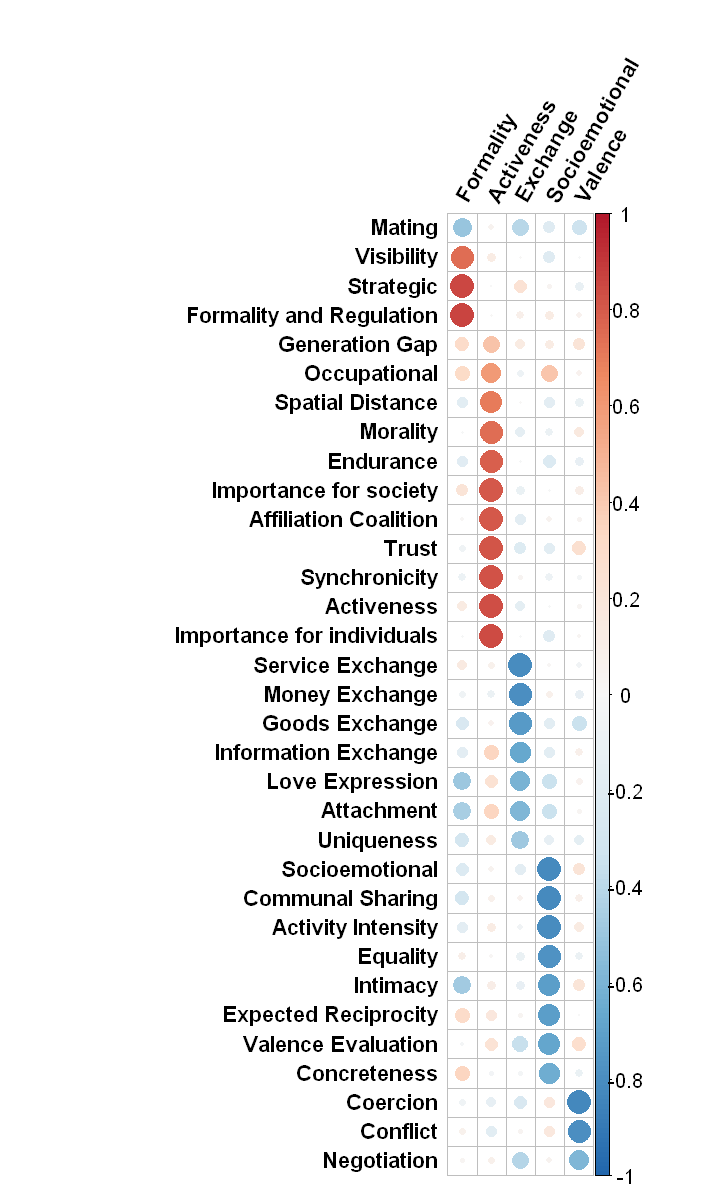

In [4]:
dim_rel_scaled_33d = read.csv('../output_data/cleaning_results/India/India_dim_rel_scaled.csv',
                          row.names=1,encoding='UTF-8',check.names=FALSE)

dim_rel.pca = prcomp(dim_rel_scaled_33d)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/India/India_loadings_var_5c_33d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/India/India_scores_var_5c_33d.csv')

#####################################################################################
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Formality','Activeness','Exchange','Socioemotional','Valence')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))